In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pathlib

sys.path.append(str(pathlib.Path().cwd().parent))

In [3]:
from typing import Tuple

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from load_dataset import Dataset
from plotting import plot_ts

2023-04-17 19:44:30.538465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 19:44:34.330091: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-17 19:44:34.330169: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-17 19:44:40.658956: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Пример. Использование полносвязной сети в классической постановке задачи прогнозирования одномерного ряда (n лагов в качестве признаков, 1 лаг в качестве ответа).

#### Возьмем уже известный ряд international-airline-passengers.csv

In [4]:
dataset = Dataset('../data/dataset/')

In [5]:
ts = dataset['international-airline-passengers.csv']

/home/nikita/Документы/time_series_course/ts_march_2023/load_dataset.py:34: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ts = pd.read_csv(


In [6]:
ts.head()

1949-01
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
Name: 112, dtype: int64

In [7]:
ts.values

array([118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115, 126,
       141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150, 178,
       163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193, 181,
       183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235, 229,
       243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234, 264,
       302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315, 364,
       347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413, 405,
       355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465, 467, 404,
       347, 305, 336, 340, 318, 362, 348, 363, 435, 491, 505, 404, 359,
       310, 337, 360, 342, 406, 396, 420, 472, 548, 559, 463, 407, 362,
       405, 417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432])

<Axes: xlabel='1949-01'>

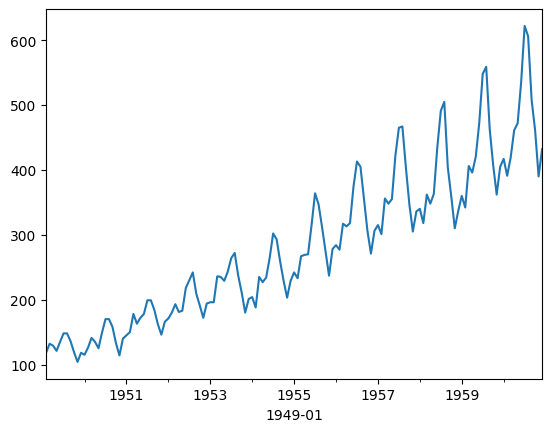

In [8]:
ts.plot()

#### Зададим количество лагов и разобъем на train и test.

In [9]:
num_lags = 12

In [10]:
ts_train, ts_test = ts[:100], ts[100 - num_lags:]

#### Возьмем нашу функцию для перехода к supervised задаче с одной точкой в качестве ответа

In [11]:
def transform_into_matrix(ts: pd.Series, num_lags: int) -> Tuple[np.array]:
    """
    Transforms time series into lags matrix to allow
    applying supervised learning algorithms

    Parameters
    ------------
    ts
        Time series to transform
    num_lags
        Number of lags to use

    Returns
    --------
        train, test: np.arrays of shapes (ts-num_lags, num_lags), (num_lags,)
    """

    ts_values = ts.values
    data = {}
    for i in range(num_lags + 1):
        data[f'lag_{num_lags - i}'] = np.roll(ts_values, -i)

    lags_matrix = pd.DataFrame(data)[:-num_lags]
    lags_matrix.index = ts.index[num_lags:]

    return lags_matrix.drop('lag_0', axis=1).values, lags_matrix['lag_0'].values

In [12]:
X_train, y_train = transform_into_matrix(ts_train, num_lags)

In [13]:
X_test, y_test = transform_into_matrix(ts_test, num_lags)

#### Зададим однослойную сеть с 64 нейронами на входном слое, и размерностью, равной количество лагов.

In [14]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=num_lags))

2021-10-11 18:15:19.242025: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Зададим выходной слой с одним нейроном

In [15]:
model.add(Dense(1))

#### Скомпилируем и обучим сетку.

In [16]:
model.compile(optimizer='adam', loss='mse')

In [17]:
model.fit(X_train, y_train, epochs=2000, verbose=0)

2021-10-11 18:15:23.040969: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


#### Получим one-step-ahead прогноз на тест

In [18]:
y_pred = model.predict(X_test)

In [19]:
plot_ts(ts_train, ts_test, pd.Series(y_pred.squeeze(), index=ts_test.index[num_lags:]))

Loading BokehJS ...

#### Мы видим достаточно неплохое качество прогноза, однако каких-то качественных улучшений по сравнению с линейной регрессией, запущенной из коробки мы не видим.

In [20]:
from model import TimeSeriesPredictor

predictor = TimeSeriesPredictor(granularity='P1M', num_lags=12)

In [21]:
predictor.fit(ts_train)

In [22]:
preds = predictor.predict_batch(ts_train, ts_test)

In [23]:
plot_ts(ts, preds)

Loading BokehJS ...

#### Тем не менее, в плане out-of-sample прогноза, запущенная из коробки lr показывает беду

In [24]:
preds_out_of_sample = predictor.predict_next(ts_train, len(ts_test))

In [25]:
plot_ts(ts, preds_out_of_sample)

Loading BokehJS ...

## Решение - попробуем сформировать датасет так, чтобы учиться предсказать сразу 12 точек! Для этого как раз удобно использовать полносвязную сеть.

### Задание 1. Использование полносвязной сети для предсказания следующих 12 точек

### Задача - по предыдущем n точкам научиться предсказывать следующие m точек

In [98]:
ts = dataset['alcohol_sales.csv']

/home/nikita/Документы/time_series_course/ts_march_2023/load_dataset.py:34: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ts = pd.read_csv(


<Axes: xlabel='0'>

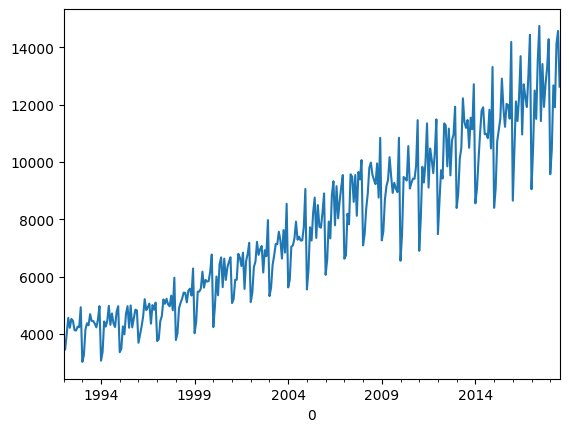

In [99]:
ts.plot()

### 1) Реализовать функцию разбиения одномерного ряда на входные данные для сетки

* принимает на вход ряд, количество входных и выходных лагов
* функция должна пройтись скользящим оконом ширины num_lags_in по временному ряду и для каждой итерации получить в качестве ответов следующие num_lags_out количество лагов
* каждый раз окно сдвигается на 1 лаг
* возращает два np.array X, y

In [102]:
# from typing import Tuple

# def transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
#     """
#     Данная функция должна пройтись скользящим окном по временному ряду и для каждых
#     num_lags_in точек в качестве признаков собрать num_lags_out следующих точек в качестве таргета.
    
#     Вернуть два np.array массива из X_train и y_train соответственно
#     """
#     ts_values = ts.values
#     data = {}
#     for i in range(num_lags_in +  num_lags_out):
        
#         data[f'lag_{num_lags - i}'] = np.roll(ts_values, -i)
        
#     lags_matrix = pd.DataFrame(data)[:-(num_lags+num_lags_out)]
#     lags_matrix.index = ts.index[num_lags+num_lags_out:]
    
#     X = lags_matrix.iloc[:, :num_lags_in]
#     y = lags_matrix.iloc[:, num_lags_in:]
#     # your code here
#     return np.array(X), np.array(y)

In [101]:
from typing import Tuple

def transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
    """
    Данная функция должна пройтись скользящим окном по временному ряду и для каждых
    num_lags_in точек в качестве признаков собрать num_lags_out следующих точек в качестве таргета.
    
    Вернуть два np.array массива из X_train и y_train соответственно
    """
    ts_values = ts.values
    X, y = [], []
    i = 0
    outer = num_lags_out
    while outer < len(ts_values):
        inner = i+num_lags_in
        outer = inner + num_lags_out
        x_ = ts_values[i:inner]
        y_ = ts_values[inner:outer]
        X.append(x_)
        y.append(y_)
        i+=1
    # your code here
    return np.array(X), np.array(y)

#### 2) Разбить на трейн и тест, отложив в качестве теста последние 12 точек (обратите внимание, что в таком случае в  качестве X_test и y_test у вас будет всего один объект)

In [103]:
X, y = transform_ts_into_matrix(ts, 24, 12)

In [104]:
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[-1:], y[-1:]

#### 3) Построить полносвязную сеть, указав нужное количество входных и выходных слоев

* в качестве архитектуры возьмите популярную конфигурацию слоев с 64 и 32 нейронами
* на первом слое необходимо указать входную размерность, равную количеству лагов на входе
* на выходном слое необхдимо указать количество нейронов, равное количеству выходных лагов
* activation, optimizer, loss можете выбрать сами, по умолчанию 'relu', 'adam', 'mse'

In [107]:
num_lags_in = 24
num_lags_out = 12

In [115]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=num_lags_in))
model.add(Dense(32, activation='relu', input_dim=64))
model.add(Dense(num_lags_out, input_dim=32))

In [116]:
X_train.shape

(283, 24)

In [117]:
model.compile(optimizer='adam', loss='mse')

#### 4) Обучить сеть.

In [118]:
model.fit(X_train, y_train, epochs=2000)

Epoch 1/2000
9/9 [==============================] - 1s 3ms/step - loss: 40375244.0000
Epoch 2/2000
9/9 [==============================] - 0s 3ms/step - loss: 22095026.0000
Epoch 3/2000
9/9 [==============================] - 0s 3ms/step - loss: 12551944.0000
Epoch 4/2000
9/9 [==============================] - 0s 4ms/step - loss: 6030809.0000
Epoch 5/2000
9/9 [==============================] - 0s 3ms/step - loss: 2437978.5000
Epoch 6/2000
9/9 [==============================] - 0s 3ms/step - loss: 1230664.3750
Epoch 7/2000
9/9 [==============================] - 0s 3ms/step - loss: 1052542.0000
Epoch 8/2000
9/9 [==============================] - 0s 4ms/step - loss: 991541.8125
Epoch 9/2000
9/9 [==============================] - 0s 3ms/step - loss: 971279.6875
Epoch 10/2000
9/9 [==============================] - 0s 4ms/step - loss: 939708.8750
Epoch 11/2000
9/9 [==============================] - 0s 3ms/step - loss: 919570.5000
Epoch 12/2000
9/9 [==============================] - 0s 3ms/step

9/9 [==============================] - 0s 3ms/step - loss: 448831.4062
Epoch 98/2000
9/9 [==============================] - 0s 3ms/step - loss: 444969.7188
Epoch 99/2000
9/9 [==============================] - 0s 3ms/step - loss: 439979.1250
Epoch 100/2000
9/9 [==============================] - 0s 3ms/step - loss: 439556.0312
Epoch 101/2000
9/9 [==============================] - 0s 4ms/step - loss: 440621.6250
Epoch 102/2000
9/9 [==============================] - 0s 3ms/step - loss: 434624.0938
Epoch 103/2000
9/9 [==============================] - 0s 3ms/step - loss: 435731.7500
Epoch 104/2000
9/9 [==============================] - 0s 3ms/step - loss: 434382.0000
Epoch 105/2000
9/9 [==============================] - 0s 3ms/step - loss: 430478.1250
Epoch 106/2000
9/9 [==============================] - 0s 3ms/step - loss: 428910.6875
Epoch 107/2000
9/9 [==============================] - 0s 3ms/step - loss: 430013.0000
Epoch 108/2000
9/9 [==============================] - 0s 3ms/step - los

9/9 [==============================] - 0s 3ms/step - loss: 301174.9375
Epoch 193/2000
9/9 [==============================] - 0s 4ms/step - loss: 292685.4688
Epoch 194/2000
9/9 [==============================] - 0s 3ms/step - loss: 294701.6562
Epoch 195/2000
9/9 [==============================] - 0s 3ms/step - loss: 291105.6562
Epoch 196/2000
9/9 [==============================] - 0s 3ms/step - loss: 297631.3438
Epoch 197/2000
9/9 [==============================] - 0s 3ms/step - loss: 299663.5312
Epoch 198/2000
9/9 [==============================] - 0s 4ms/step - loss: 292199.5000
Epoch 199/2000
9/9 [==============================] - 0s 3ms/step - loss: 284943.9375
Epoch 200/2000
9/9 [==============================] - 0s 3ms/step - loss: 280350.6562
Epoch 201/2000
9/9 [==============================] - 0s 3ms/step - loss: 280413.8125
Epoch 202/2000
9/9 [==============================] - 0s 4ms/step - loss: 285655.0000
Epoch 203/2000
9/9 [==============================] - 0s 3ms/step - l

9/9 [==============================] - 0s 13ms/step - loss: 228236.5156
Epoch 288/2000
9/9 [==============================] - 0s 10ms/step - loss: 227153.2969
Epoch 289/2000
9/9 [==============================] - 0s 12ms/step - loss: 228203.9062
Epoch 290/2000
9/9 [==============================] - 0s 12ms/step - loss: 228573.4062
Epoch 291/2000
9/9 [==============================] - 0s 12ms/step - loss: 227330.5938
Epoch 292/2000
9/9 [==============================] - 0s 12ms/step - loss: 224991.9688
Epoch 293/2000
9/9 [==============================] - 0s 11ms/step - loss: 222245.1250
Epoch 294/2000
9/9 [==============================] - 0s 12ms/step - loss: 225026.7031
Epoch 295/2000
9/9 [==============================] - 0s 11ms/step - loss: 231529.5312
Epoch 296/2000
9/9 [==============================] - 0s 12ms/step - loss: 225796.7500
Epoch 297/2000
9/9 [==============================] - 0s 12ms/step - loss: 223322.8281
Epoch 298/2000
9/9 [==============================] - 0s 1

9/9 [==============================] - 0s 12ms/step - loss: 192573.6250
Epoch 382/2000
9/9 [==============================] - 0s 11ms/step - loss: 191422.8125
Epoch 383/2000
9/9 [==============================] - 0s 12ms/step - loss: 189725.2656
Epoch 384/2000
9/9 [==============================] - 0s 11ms/step - loss: 190675.3281
Epoch 385/2000
9/9 [==============================] - 0s 9ms/step - loss: 192253.1562
Epoch 386/2000
9/9 [==============================] - 0s 12ms/step - loss: 190649.5781
Epoch 387/2000
9/9 [==============================] - 0s 12ms/step - loss: 191954.4062
Epoch 388/2000
9/9 [==============================] - 0s 12ms/step - loss: 192890.1406
Epoch 389/2000
9/9 [==============================] - 0s 11ms/step - loss: 197224.4062
Epoch 390/2000
9/9 [==============================] - 0s 11ms/step - loss: 191058.8906
Epoch 391/2000
9/9 [==============================] - 0s 10ms/step - loss: 194167.0156
Epoch 392/2000
9/9 [==============================] - 0s 12

9/9 [==============================] - 0s 11ms/step - loss: 170438.1250
Epoch 476/2000
9/9 [==============================] - 0s 10ms/step - loss: 167388.0781
Epoch 477/2000
9/9 [==============================] - 0s 10ms/step - loss: 175067.9844
Epoch 478/2000
9/9 [==============================] - 0s 10ms/step - loss: 177291.6250
Epoch 479/2000
9/9 [==============================] - 0s 10ms/step - loss: 171124.5938
Epoch 480/2000
9/9 [==============================] - 0s 12ms/step - loss: 169071.2656
Epoch 481/2000
9/9 [==============================] - 0s 10ms/step - loss: 165109.7031
Epoch 482/2000
9/9 [==============================] - 0s 11ms/step - loss: 171041.8125
Epoch 483/2000
9/9 [==============================] - 0s 13ms/step - loss: 166975.0000
Epoch 484/2000
9/9 [==============================] - 0s 11ms/step - loss: 167915.0781
Epoch 485/2000
9/9 [==============================] - 0s 11ms/step - loss: 170181.6250
Epoch 486/2000
9/9 [==============================] - 0s 1

9/9 [==============================] - 0s 3ms/step - loss: 153100.6094
Epoch 570/2000
9/9 [==============================] - 0s 3ms/step - loss: 156971.6250
Epoch 571/2000
9/9 [==============================] - 0s 3ms/step - loss: 153806.1406
Epoch 572/2000
9/9 [==============================] - 0s 2ms/step - loss: 153407.9844
Epoch 573/2000
9/9 [==============================] - 0s 3ms/step - loss: 150031.0156
Epoch 574/2000
9/9 [==============================] - 0s 3ms/step - loss: 153148.8594
Epoch 575/2000
9/9 [==============================] - 0s 3ms/step - loss: 150166.1406
Epoch 576/2000
9/9 [==============================] - 0s 3ms/step - loss: 151561.8438
Epoch 577/2000
9/9 [==============================] - 0s 4ms/step - loss: 150469.5625
Epoch 578/2000
9/9 [==============================] - 0s 3ms/step - loss: 148692.0312
Epoch 579/2000
9/9 [==============================] - 0s 3ms/step - loss: 153187.6562
Epoch 580/2000
9/9 [==============================] - 0s 4ms/step - l

9/9 [==============================] - 0s 3ms/step - loss: 133784.1562
Epoch 665/2000
9/9 [==============================] - 0s 3ms/step - loss: 140686.1406
Epoch 666/2000
9/9 [==============================] - 0s 3ms/step - loss: 142368.7969
Epoch 667/2000
9/9 [==============================] - 0s 3ms/step - loss: 142963.0156
Epoch 668/2000
9/9 [==============================] - 0s 3ms/step - loss: 143322.0312
Epoch 669/2000
9/9 [==============================] - 0s 3ms/step - loss: 138497.0000
Epoch 670/2000
9/9 [==============================] - 0s 3ms/step - loss: 140639.6094
Epoch 671/2000
9/9 [==============================] - 0s 3ms/step - loss: 137439.6875
Epoch 672/2000
9/9 [==============================] - 0s 3ms/step - loss: 139130.0469
Epoch 673/2000
9/9 [==============================] - 0s 3ms/step - loss: 139687.4844
Epoch 674/2000
9/9 [==============================] - 0s 3ms/step - loss: 132875.6719
Epoch 675/2000
9/9 [==============================] - 0s 3ms/step - l

9/9 [==============================] - 0s 3ms/step - loss: 119558.7969
Epoch 760/2000
9/9 [==============================] - 0s 3ms/step - loss: 122727.7031
Epoch 761/2000
9/9 [==============================] - 0s 3ms/step - loss: 118786.1094
Epoch 762/2000
9/9 [==============================] - 0s 3ms/step - loss: 119358.7266
Epoch 763/2000
9/9 [==============================] - 0s 3ms/step - loss: 120851.6484
Epoch 764/2000
9/9 [==============================] - 0s 3ms/step - loss: 123630.7969
Epoch 765/2000
9/9 [==============================] - 0s 3ms/step - loss: 122337.4844
Epoch 766/2000
9/9 [==============================] - 0s 2ms/step - loss: 120401.8516
Epoch 767/2000
9/9 [==============================] - 0s 3ms/step - loss: 119687.0938
Epoch 768/2000
9/9 [==============================] - 0s 3ms/step - loss: 117029.6719
Epoch 769/2000
9/9 [==============================] - 0s 3ms/step - loss: 119885.4453
Epoch 770/2000
9/9 [==============================] - 0s 3ms/step - l

9/9 [==============================] - 0s 6ms/step - loss: 115158.1875
Epoch 855/2000
9/9 [==============================] - 0s 4ms/step - loss: 123328.6484
Epoch 856/2000
9/9 [==============================] - 0s 3ms/step - loss: 121777.6953
Epoch 857/2000
9/9 [==============================] - 0s 4ms/step - loss: 123598.1797
Epoch 858/2000
9/9 [==============================] - 0s 4ms/step - loss: 123495.7734
Epoch 859/2000
9/9 [==============================] - 0s 4ms/step - loss: 118023.9453
Epoch 860/2000
9/9 [==============================] - 0s 4ms/step - loss: 122324.5625
Epoch 861/2000
9/9 [==============================] - 0s 4ms/step - loss: 121173.0312
Epoch 862/2000
9/9 [==============================] - 0s 4ms/step - loss: 114363.5703
Epoch 863/2000
9/9 [==============================] - 0s 5ms/step - loss: 114999.8828
Epoch 864/2000
9/9 [==============================] - 0s 6ms/step - loss: 119738.0469
Epoch 865/2000
9/9 [==============================] - 0s 4ms/step - l

9/9 [==============================] - 0s 3ms/step - loss: 111680.2109
Epoch 950/2000
9/9 [==============================] - 0s 3ms/step - loss: 108883.1484
Epoch 951/2000
9/9 [==============================] - 0s 3ms/step - loss: 109924.3672
Epoch 952/2000
9/9 [==============================] - 0s 3ms/step - loss: 108065.5391
Epoch 953/2000
9/9 [==============================] - 0s 2ms/step - loss: 110345.8203
Epoch 954/2000
9/9 [==============================] - 0s 3ms/step - loss: 109471.0938
Epoch 955/2000
9/9 [==============================] - 0s 3ms/step - loss: 116836.5547
Epoch 956/2000
9/9 [==============================] - 0s 3ms/step - loss: 111842.7734
Epoch 957/2000
9/9 [==============================] - 0s 3ms/step - loss: 111248.3203
Epoch 958/2000
9/9 [==============================] - 0s 2ms/step - loss: 113359.2812
Epoch 959/2000
9/9 [==============================] - 0s 3ms/step - loss: 110671.6172
Epoch 960/2000
9/9 [==============================] - 0s 3ms/step - l

9/9 [==============================] - 0s 3ms/step - loss: 108348.0703
Epoch 1044/2000
9/9 [==============================] - 0s 3ms/step - loss: 107940.7578
Epoch 1045/2000
9/9 [==============================] - 0s 3ms/step - loss: 108775.7812
Epoch 1046/2000
9/9 [==============================] - 0s 3ms/step - loss: 113058.8047
Epoch 1047/2000
9/9 [==============================] - 0s 2ms/step - loss: 111951.2891
Epoch 1048/2000
9/9 [==============================] - 0s 3ms/step - loss: 119298.8516
Epoch 1049/2000
9/9 [==============================] - 0s 2ms/step - loss: 116240.2891
Epoch 1050/2000
9/9 [==============================] - 0s 4ms/step - loss: 113513.9688
Epoch 1051/2000
9/9 [==============================] - 0s 3ms/step - loss: 110931.8672
Epoch 1052/2000
9/9 [==============================] - 0s 3ms/step - loss: 109220.5156
Epoch 1053/2000
9/9 [==============================] - 0s 3ms/step - loss: 108826.1641
Epoch 1054/2000
9/9 [==============================] - 0s 3

9/9 [==============================] - 0s 3ms/step - loss: 107954.5078
Epoch 1138/2000
9/9 [==============================] - 0s 2ms/step - loss: 106230.1094
Epoch 1139/2000
9/9 [==============================] - 0s 3ms/step - loss: 107404.6953
Epoch 1140/2000
9/9 [==============================] - 0s 3ms/step - loss: 108965.0000
Epoch 1141/2000
9/9 [==============================] - 0s 3ms/step - loss: 113112.1016
Epoch 1142/2000
9/9 [==============================] - 0s 3ms/step - loss: 112751.1250
Epoch 1143/2000
9/9 [==============================] - 0s 3ms/step - loss: 109845.7031
Epoch 1144/2000
9/9 [==============================] - 0s 3ms/step - loss: 108989.5312
Epoch 1145/2000
9/9 [==============================] - 0s 3ms/step - loss: 107840.7812
Epoch 1146/2000
9/9 [==============================] - 0s 3ms/step - loss: 105153.4688
Epoch 1147/2000
9/9 [==============================] - 0s 2ms/step - loss: 103902.3125
Epoch 1148/2000
9/9 [==============================] - 0s 3

9/9 [==============================] - 0s 3ms/step - loss: 111663.2266
Epoch 1232/2000
9/9 [==============================] - 0s 3ms/step - loss: 112241.5547
Epoch 1233/2000
9/9 [==============================] - 0s 2ms/step - loss: 107426.1094
Epoch 1234/2000
9/9 [==============================] - 0s 3ms/step - loss: 106785.1797
Epoch 1235/2000
9/9 [==============================] - 0s 3ms/step - loss: 114672.3359
Epoch 1236/2000
9/9 [==============================] - 0s 2ms/step - loss: 112456.4609
Epoch 1237/2000
9/9 [==============================] - 0s 3ms/step - loss: 108896.2969
Epoch 1238/2000
9/9 [==============================] - 0s 3ms/step - loss: 117987.7422
Epoch 1239/2000
9/9 [==============================] - 0s 3ms/step - loss: 107297.6250
Epoch 1240/2000
9/9 [==============================] - 0s 3ms/step - loss: 105545.0156
Epoch 1241/2000
9/9 [==============================] - 0s 4ms/step - loss: 105994.9375
Epoch 1242/2000
9/9 [==============================] - 0s 3

9/9 [==============================] - 0s 3ms/step - loss: 101836.0703
Epoch 1326/2000
9/9 [==============================] - 0s 3ms/step - loss: 102682.6016
Epoch 1327/2000
9/9 [==============================] - 0s 3ms/step - loss: 110692.0391
Epoch 1328/2000
9/9 [==============================] - 0s 2ms/step - loss: 106371.5156
Epoch 1329/2000
9/9 [==============================] - 0s 2ms/step - loss: 107091.7031
Epoch 1330/2000
9/9 [==============================] - 0s 3ms/step - loss: 108388.5547
Epoch 1331/2000
9/9 [==============================] - 0s 3ms/step - loss: 110597.5859
Epoch 1332/2000
9/9 [==============================] - 0s 3ms/step - loss: 101694.1641
Epoch 1333/2000
9/9 [==============================] - 0s 3ms/step - loss: 103469.8125
Epoch 1334/2000
9/9 [==============================] - 0s 3ms/step - loss: 104536.3516
Epoch 1335/2000
9/9 [==============================] - 0s 3ms/step - loss: 101010.9062
Epoch 1336/2000
9/9 [==============================] - 0s 3

9/9 [==============================] - 0s 3ms/step - loss: 101498.5703
Epoch 1420/2000
9/9 [==============================] - 0s 3ms/step - loss: 101670.6484
Epoch 1421/2000
9/9 [==============================] - 0s 3ms/step - loss: 100558.4766
Epoch 1422/2000
9/9 [==============================] - 0s 4ms/step - loss: 101931.3906
Epoch 1423/2000
9/9 [==============================] - 0s 3ms/step - loss: 101417.6406
Epoch 1424/2000
9/9 [==============================] - 0s 3ms/step - loss: 102670.0156
Epoch 1425/2000
9/9 [==============================] - 0s 3ms/step - loss: 101340.6484
Epoch 1426/2000
9/9 [==============================] - 0s 3ms/step - loss: 102395.7422
Epoch 1427/2000
9/9 [==============================] - 0s 3ms/step - loss: 98955.8438
Epoch 1428/2000
9/9 [==============================] - 0s 2ms/step - loss: 101197.7188
Epoch 1429/2000
9/9 [==============================] - 0s 3ms/step - loss: 104603.9609
Epoch 1430/2000
9/9 [==============================] - 0s 3m

9/9 [==============================] - 0s 3ms/step - loss: 99421.0469
Epoch 1514/2000
9/9 [==============================] - 0s 4ms/step - loss: 99996.2734
Epoch 1515/2000
9/9 [==============================] - 0s 3ms/step - loss: 102253.9688
Epoch 1516/2000
9/9 [==============================] - 0s 3ms/step - loss: 101883.1641
Epoch 1517/2000
9/9 [==============================] - 0s 3ms/step - loss: 100692.7344
Epoch 1518/2000
9/9 [==============================] - 0s 3ms/step - loss: 99834.5469
Epoch 1519/2000
9/9 [==============================] - 0s 3ms/step - loss: 104471.8125
Epoch 1520/2000
9/9 [==============================] - 0s 3ms/step - loss: 104007.7188
Epoch 1521/2000
9/9 [==============================] - 0s 4ms/step - loss: 105139.8125
Epoch 1522/2000
9/9 [==============================] - 0s 3ms/step - loss: 106337.6719
Epoch 1523/2000
9/9 [==============================] - 0s 2ms/step - loss: 102259.9922
Epoch 1524/2000
9/9 [==============================] - 0s 3ms/

9/9 [==============================] - 0s 5ms/step - loss: 103797.9531
Epoch 1608/2000
9/9 [==============================] - 0s 4ms/step - loss: 103785.1406
Epoch 1609/2000
9/9 [==============================] - 0s 3ms/step - loss: 107680.9531
Epoch 1610/2000
9/9 [==============================] - 0s 3ms/step - loss: 101616.7734
Epoch 1611/2000
9/9 [==============================] - 0s 3ms/step - loss: 103087.9609
Epoch 1612/2000
9/9 [==============================] - 0s 3ms/step - loss: 105016.6719
Epoch 1613/2000
9/9 [==============================] - 0s 3ms/step - loss: 104231.4609
Epoch 1614/2000
9/9 [==============================] - 0s 3ms/step - loss: 102116.6406
Epoch 1615/2000
9/9 [==============================] - 0s 3ms/step - loss: 101994.1641
Epoch 1616/2000
9/9 [==============================] - 0s 3ms/step - loss: 105416.5625
Epoch 1617/2000
9/9 [==============================] - 0s 3ms/step - loss: 100076.4453
Epoch 1618/2000
9/9 [==============================] - 0s 3

9/9 [==============================] - 0s 2ms/step - loss: 104191.1719
Epoch 1702/2000
9/9 [==============================] - 0s 3ms/step - loss: 105501.1328
Epoch 1703/2000
9/9 [==============================] - 0s 3ms/step - loss: 101950.6328
Epoch 1704/2000
9/9 [==============================] - 0s 4ms/step - loss: 102165.9453
Epoch 1705/2000
9/9 [==============================] - 0s 3ms/step - loss: 100313.1875
Epoch 1706/2000
9/9 [==============================] - 0s 4ms/step - loss: 100788.0547
Epoch 1707/2000
9/9 [==============================] - 0s 2ms/step - loss: 110972.2734
Epoch 1708/2000
9/9 [==============================] - 0s 3ms/step - loss: 99498.8359
Epoch 1709/2000
9/9 [==============================] - 0s 3ms/step - loss: 103137.3750
Epoch 1710/2000
9/9 [==============================] - 0s 3ms/step - loss: 95680.1172
Epoch 1711/2000
9/9 [==============================] - 0s 3ms/step - loss: 96638.5234
Epoch 1712/2000
9/9 [==============================] - 0s 3ms/

9/9 [==============================] - 0s 3ms/step - loss: 111236.0859
Epoch 1796/2000
9/9 [==============================] - 0s 3ms/step - loss: 104687.4219
Epoch 1797/2000
9/9 [==============================] - 0s 3ms/step - loss: 105032.8594
Epoch 1798/2000
9/9 [==============================] - 0s 3ms/step - loss: 99190.8125
Epoch 1799/2000
9/9 [==============================] - 0s 2ms/step - loss: 102039.7422
Epoch 1800/2000
9/9 [==============================] - 0s 3ms/step - loss: 103862.6719
Epoch 1801/2000
9/9 [==============================] - 0s 2ms/step - loss: 110551.6875
Epoch 1802/2000
9/9 [==============================] - 0s 3ms/step - loss: 105769.2031
Epoch 1803/2000
9/9 [==============================] - 0s 3ms/step - loss: 101520.7266
Epoch 1804/2000
9/9 [==============================] - 0s 3ms/step - loss: 101603.9844
Epoch 1805/2000
9/9 [==============================] - 0s 3ms/step - loss: 100141.1875
Epoch 1806/2000
9/9 [==============================] - 0s 3m

9/9 [==============================] - 0s 3ms/step - loss: 97450.9922
Epoch 1890/2000
9/9 [==============================] - 0s 3ms/step - loss: 106936.3828
Epoch 1891/2000
9/9 [==============================] - 0s 3ms/step - loss: 104961.8906
Epoch 1892/2000
9/9 [==============================] - 0s 3ms/step - loss: 105557.0391
Epoch 1893/2000
9/9 [==============================] - 0s 5ms/step - loss: 106110.5547
Epoch 1894/2000
9/9 [==============================] - 0s 3ms/step - loss: 103777.8672
Epoch 1895/2000
9/9 [==============================] - 0s 3ms/step - loss: 109567.4062
Epoch 1896/2000
9/9 [==============================] - 0s 3ms/step - loss: 117272.6250
Epoch 1897/2000
9/9 [==============================] - 0s 3ms/step - loss: 111422.6328
Epoch 1898/2000
9/9 [==============================] - 0s 3ms/step - loss: 106077.4297
Epoch 1899/2000
9/9 [==============================] - 0s 2ms/step - loss: 100953.3203
Epoch 1900/2000
9/9 [==============================] - 0s 3m

9/9 [==============================] - 0s 3ms/step - loss: 95289.9922
Epoch 1985/2000
9/9 [==============================] - 0s 3ms/step - loss: 96662.0234
Epoch 1986/2000
9/9 [==============================] - 0s 4ms/step - loss: 97559.1562
Epoch 1987/2000
9/9 [==============================] - 0s 3ms/step - loss: 94959.7812
Epoch 1988/2000
9/9 [==============================] - 0s 3ms/step - loss: 95083.3984
Epoch 1989/2000
9/9 [==============================] - 0s 3ms/step - loss: 98527.4844
Epoch 1990/2000
9/9 [==============================] - 0s 3ms/step - loss: 99894.8594
Epoch 1991/2000
9/9 [==============================] - 0s 3ms/step - loss: 97091.6562
Epoch 1992/2000
9/9 [==============================] - 0s 3ms/step - loss: 99819.7734
Epoch 1993/2000
9/9 [==============================] - 0s 3ms/step - loss: 99594.2578
Epoch 1994/2000
9/9 [==============================] - 0s 2ms/step - loss: 99090.0391
Epoch 1995/2000
9/9 [==============================] - 0s 3ms/step - l

#### 5) Сделайте предикт на тесте и сравните результат с предыдущим подходом

In [119]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 103ms/step


In [120]:
plot_ts(ts, pd.Series(y_pred.flatten(), index = ts.index[-12:]))

Loading BokehJS ...

### Использование полносвязной сети для предсказания многомерного ряда

In [121]:
ts = pd.read_csv('../data/stability_index.csv', index_col='timestamp', parse_dates=True)

In [123]:
ts.head()

,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,
2020-01-15 13:00:00,205.0,92.0,63.0,55.0,26.0,27.0,20.0,34.0,155.0
2020-01-15 14:00:00,173.0,97.0,69.0,44.0,31.0,22.0,41.0,26.0,182.0
2020-01-15 15:00:00,145.0,83.0,73.0,58.0,40.0,25.0,31.0,19.0,167.0
2020-01-15 16:00:00,84.0,60.0,53.0,39.0,32.0,31.0,19.0,15.0,102.0
2020-01-15 17:00:00,117.0,77.0,40.0,53.0,33.0,29.0,21.0,30.0,160.0


<Axes: xlabel='timestamp'>

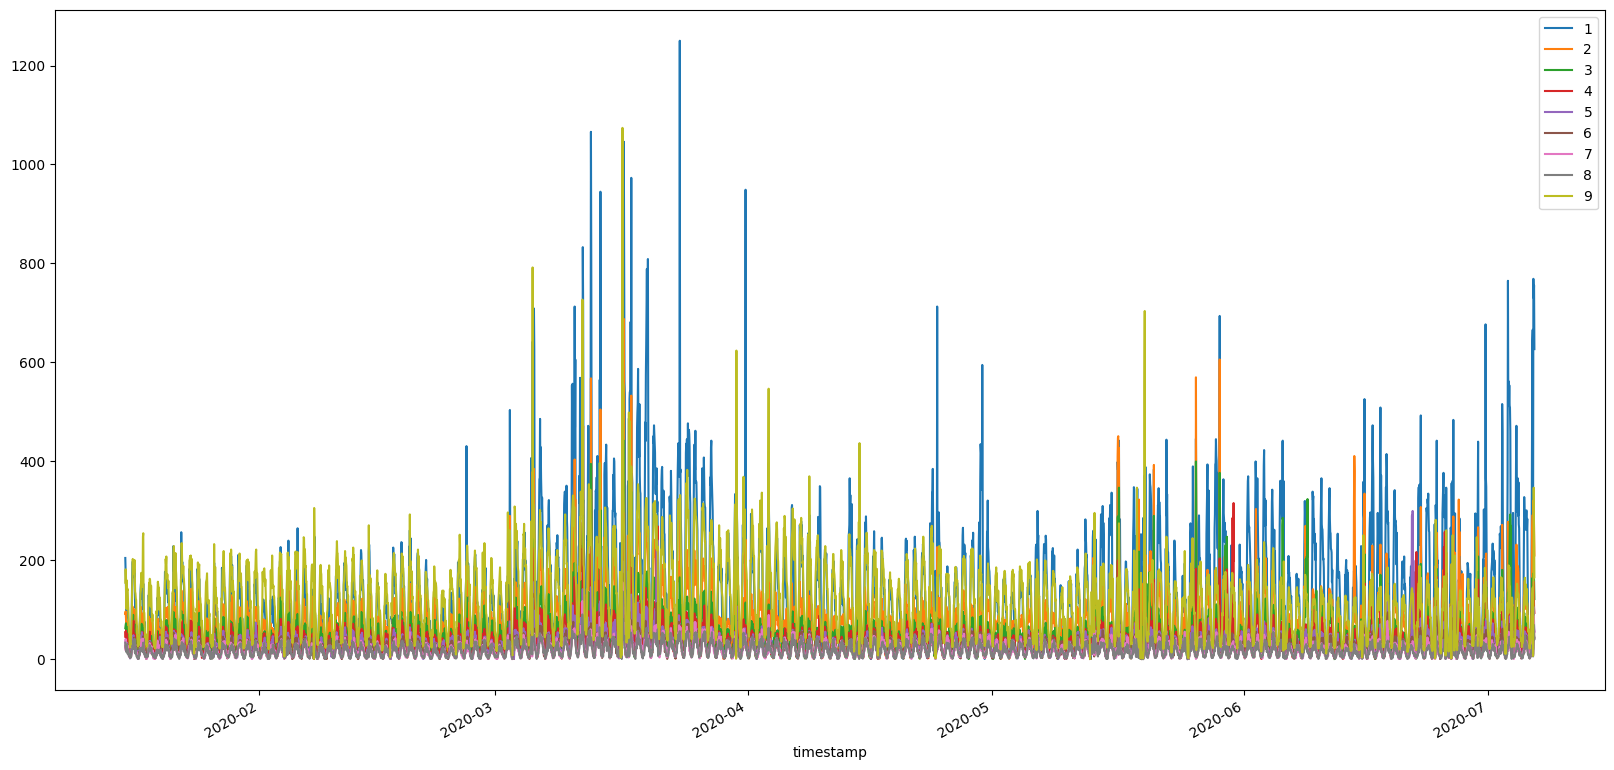

In [124]:
ts.plot(figsize=(20, 10))

In [125]:
ts.fillna(ts.median(), inplace=True)

In [126]:
ts.head()

,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,
2020-01-15 13:00:00,205.0,92.0,63.0,55.0,26.0,27.0,20.0,34.0,155.0
2020-01-15 14:00:00,173.0,97.0,69.0,44.0,31.0,22.0,41.0,26.0,182.0
2020-01-15 15:00:00,145.0,83.0,73.0,58.0,40.0,25.0,31.0,19.0,167.0
2020-01-15 16:00:00,84.0,60.0,53.0,39.0,32.0,31.0,19.0,15.0,102.0
2020-01-15 17:00:00,117.0,77.0,40.0,53.0,33.0,29.0,21.0,30.0,160.0


#### 1) Реализовать функцию, которая разбивает исходный ряд на входные данные X и y для сетки

In [131]:
ts.iloc[3:5].values

array([[ 84.,  60.,  53.,  39.,  32.,  31.,  19.,  15., 102.],
       [117.,  77.,  40.,  53.,  33.,  29.,  21.,  30., 160.]])

In [157]:
def transform_multi_ts_into_matrix(ts: pd.DataFrame, num_lags: int):
    """
    Данная функция должна пройтись скользящим окном по временному ряду
    и собрать в качестве признаков X np.array размерности (len(ts)-num_lags, n_dims, num_lags),
    а в качестве y np.array размерности (len(ts)-num_lags, n_dims),
    где n_dims - размерность многомерного ряда.
    
    То есть для всех компонент временного ряда мы должны взять num_lags предыдущих точек каждой компонент
    в качестве признаков и все компоненты текущей точки в качестве target
    """
    X, y = [], []
    left = 0
    right = num_lags
    while right<len(ts):
        X.append(ts.iloc[left:right].values.flatten())
        y.append(ts.iloc[right])
        left+=1
        right+=1
    
    return np.array(X), np.array(y)

In [158]:
n_lags = 24

In [159]:
X, y = transform_multi_ts_into_matrix(ts, n_lags)

In [160]:
X[0].shape

(216,)

In [161]:
X.shape

(4121, 216)

In [162]:
y.shape

(4121, 9)

#### 2) Разбить на трейн и тест

In [163]:
idx_split = int(len(X)*0.8)
X_train, y_train = X[:idx_split], y [:idx_split]
X_test, y_test = X[idx_split:], y [idx_split:]

#### 3) Построить полносвязную сеть, указав нужное количество входных и выходных слоев

In [164]:
from tensorflow.keras.layers import Dropout

In [168]:
n_dim = len(ts.columns)
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=n_lags*n_dim))
# model.add(Dense(32, activation='relu', input_dim=64))
model.add(Dense(n_dim, input_dim=64))

In [169]:
X_train.shape

(3296, 216)

In [170]:
model.compile(optimizer='adam', loss='mse')

####  4) Обучить модель 

In [171]:
model.fit(X_train, y_train, epochs=300)

Epoch 1/300
103/103 [==============================] - 1s 2ms/step - loss: 1975.8087
Epoch 2/300
103/103 [==============================] - 0s 2ms/step - loss: 1191.6489
Epoch 3/300
103/103 [==============================] - 0s 2ms/step - loss: 1060.0277
Epoch 4/300
103/103 [==============================] - 0s 2ms/step - loss: 986.8981
Epoch 5/300
103/103 [==============================] - 0s 3ms/step - loss: 931.9351
Epoch 6/300
103/103 [==============================] - 0s 3ms/step - loss: 888.6325
Epoch 7/300
103/103 [==============================] - 0s 2ms/step - loss: 877.0825
Epoch 8/300
103/103 [==============================] - 0s 2ms/step - loss: 867.0793
Epoch 9/300
103/103 [==============================] - 0s 2ms/step - loss: 842.5199
Epoch 10/300
103/103 [==============================] - 0s 3ms/step - loss: 816.3499
Epoch 11/300
103/103 [==============================] - 0s 3ms/step - loss: 817.8853
Epoch 12/300
103/103 [==============================] - 0s 2ms/step - l

103/103 [==============================] - 0s 2ms/step - loss: 319.8675
Epoch 98/300
103/103 [==============================] - 0s 3ms/step - loss: 332.0413
Epoch 99/300
103/103 [==============================] - 0s 3ms/step - loss: 323.8690
Epoch 100/300
103/103 [==============================] - 0s 3ms/step - loss: 324.4417
Epoch 101/300
103/103 [==============================] - 0s 3ms/step - loss: 322.0260
Epoch 102/300
103/103 [==============================] - 0s 3ms/step - loss: 326.0630
Epoch 103/300
103/103 [==============================] - 0s 2ms/step - loss: 314.6224
Epoch 104/300
103/103 [==============================] - 0s 2ms/step - loss: 314.2879
Epoch 105/300
103/103 [==============================] - 0s 2ms/step - loss: 316.1229
Epoch 106/300
103/103 [==============================] - 0s 3ms/step - loss: 312.7735
Epoch 107/300
103/103 [==============================] - 0s 2ms/step - loss: 299.4179
Epoch 108/300
103/103 [==============================] - 0s 2ms/step -

103/103 [==============================] - 0s 3ms/step - loss: 215.6076
Epoch 193/300
103/103 [==============================] - 0s 2ms/step - loss: 207.7772
Epoch 194/300
103/103 [==============================] - 0s 2ms/step - loss: 212.8178
Epoch 195/300
103/103 [==============================] - 0s 2ms/step - loss: 204.1084
Epoch 196/300
103/103 [==============================] - 0s 2ms/step - loss: 212.6333
Epoch 197/300
103/103 [==============================] - 0s 3ms/step - loss: 218.1483
Epoch 198/300
103/103 [==============================] - 0s 2ms/step - loss: 216.8947
Epoch 199/300
103/103 [==============================] - 0s 2ms/step - loss: 215.8520
Epoch 200/300
103/103 [==============================] - 0s 2ms/step - loss: 221.1033
Epoch 201/300
103/103 [==============================] - 0s 2ms/step - loss: 216.0636
Epoch 202/300
103/103 [==============================] - 0s 2ms/step - loss: 216.2441
Epoch 203/300
103/103 [==============================] - 0s 2ms/step

103/103 [==============================] - 0s 2ms/step - loss: 174.3005
Epoch 288/300
103/103 [==============================] - 0s 2ms/step - loss: 181.4949
Epoch 289/300
103/103 [==============================] - 0s 3ms/step - loss: 203.2876
Epoch 290/300
103/103 [==============================] - 0s 2ms/step - loss: 193.1648
Epoch 291/300
103/103 [==============================] - 0s 2ms/step - loss: 181.6751
Epoch 292/300
103/103 [==============================] - 0s 2ms/step - loss: 186.0420
Epoch 293/300
103/103 [==============================] - 0s 2ms/step - loss: 188.3014
Epoch 294/300
103/103 [==============================] - 0s 2ms/step - loss: 180.5319
Epoch 295/300
103/103 [==============================] - 0s 2ms/step - loss: 199.8237
Epoch 296/300
103/103 [==============================] - 0s 2ms/step - loss: 194.4344
Epoch 297/300
103/103 [==============================] - 0s 2ms/step - loss: 171.0621
Epoch 298/300
103/103 [==============================] - 0s 2ms/step

#### 5) Сделайте прогноз

In [178]:
#1я компонента

In [172]:
preds = model.predict(X_test)

26/26 [==============================] - 0s 2ms/step


In [177]:
plot_ts(ts['1'][-len(preds):], pd.Series(preds[:,0], index = ts['1'].index[-len(preds):]))

Loading BokehJS ...